In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

import tf_lab.point_clouds.in_out as pio
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph



import tf_lab.autopredictors.scripts.virt_scan_data as vscan

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, points_extension, \
                                                 shape_net_core_synth_id_to_category

import tf_lab.autopredictors.scripts.iccv as iccv


from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch                                           

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion, save_reconstructions, \
                                           save_pc_prediction_stats, \
                                           paper_pc_completion_experiment_id_best_epoch
                                           
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud, Mesh
from geo_tool.solids import mesh_cleaning as cleaning

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
GPU = 0
loss = 'emd'
incomplete_n_samples = 2048
complete_n_samples = 4096
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/paper_vanilla_vscan')

In [4]:
class_type = 'all_classes'

In [5]:
experiment_id, best_epoch = paper_pc_completion_experiment_id_best_epoch(class_type, loss)
experiment_name = str(experiment_id) + '_' + class_type + '_' + str(incomplete_n_samples) + '_' \
                  + str(complete_n_samples) + 'pts_' + loss
train_dir = osp.join(train_dir, experiment_name)

In [6]:
conf = Conf.load(osp.join(train_dir, 'configuration'))
conf.consistent_io = None
conf.allow_gpu_growth = True
conf.encoder_args = {'dropout_prob': 1.0}
print conf

              allow_gpu_growth: True
                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'non_linearity': <function relu at 0x7f6c51ee5e60>, 'layer_sizes': [1024, 12288]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {'dropout_prob': 1.0}
               experiment_name: 9_all_classes_2048_4096pts_emd
                 gauss_augment: None
                  is_denoising: True
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: emd
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [4096, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 1
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incom

In [7]:
reset_tf_graph()
set_visible_GPUs([GPU])
ae = PointNetAutoEncoder(experiment_name, conf)
ae.restore_model(train_dir, best_epoch)

In [11]:
top_charles_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Charles_Real_Scans/objects/'
mesh_list = osp.join(top_charles_dir, 'objectlist.txt')
with open(mesh_list, 'r') as fin:
    mesh_list = fin.readlines()

mesh_file_list = [osp.join(top_charles_dir, i.rstrip()) for i in mesh_list]
mesh_names = [osp.basename(i)[:-len('.obj')] for i in mesh_file_list]
pc_file_list = [i[:-len('.obj')] + '_2048_samples_pts.txt' for i in mesh_file_list]

In [309]:
from tf_lab.autopredictors.scripts.charles_data import CharlesFusedData

chair_rotate_degrees = [-45, -150, -135, -115, -110, 0, -25, -10, 90, -30, -130, -45, -135, 90, 90, 60, 0]

chair_model_names = ['chair_scan_0001', 'chair_scan_0010', 'chair_scan_0016', 'chair_scan_0007',
                         'chair_scan_0011', 'chair_scan_0006', 'chair_scan_0017', 'chair_scan_0012',
                         'chair_scan_0008', 'chair_scan_0003', 'chair_scan_0005', 'chair_scan_0014',
                         'chair_scan_0002', 'chair_scan_0009', 'chair_scan_0013', 'chair_scan_0015',
                         'chair_scan_0004']

sofa_rotate_degrees = [0, 0, 100, -130, 10, -65, 60, -35, 60, 155, 120, 110, 70, 10, 0, 120, 67, 5, 5, 30, 0, 120, 5, 110, -83, -150]
sofa_model_names = ['sofa_scan_0007', 'sofa_scan_0016', 'sofa_scan_0025', 'sofa_scan_0023',
                        'sofa_scan_0010', 'sofa_scan_0001', 'sofa_scan_0017', 'sofa_scan_0006',
                        'sofa_scan_0024', 'sofa_scan_0022', 'sofa_scan_0011', 'sofa_scan_0014',
                        'sofa_scan_0005', 'sofa_scan_0003', 'sofa_scan_0019', 'sofa_scan_0012',
                        'sofa_scan_0008', 'sofa_scan_0021', 'sofa_scan_0026', 'sofa_scan_0004',
                        'sofa_scan_0015', 'sofa_scan_0009', 'sofa_scan_0013', 'sofa_scan_0018',
                        'sofa_scan_0002', 'sofa_scan_0020']


table_rotate_degrees = [30, -65, 65, -80, 20,  10,  120, -8,   40,  20, 30,  20,  10, 60,  25,  35,   10, -10]
table_azimuth_angles = [240, 0,  50, 240, 240, 240, 240, 240, 240, 240, 20, 200, 200, 200, 240, 240, 240,  30]
table_model_names = ['table_scan_0014', 'table_scan_0005', 'table_scan_0003', 'table_scan_0012',
                         'table_scan_0008', 'table_scan_0004', 'table_scan_0015', 'table_scan_0009',
                         'table_scan_0013', 'table_scan_0018', 'table_scan_0002', 'table_scan_0007',
                         'table_scan_0016', 'table_scan_0010', 'table_scan_0001', 'table_scan_0017',
                         'table_scan_0006', 'table_scan_0011']

checking_names = table_model_names
checking_degs = table_rotate_degrees
rotation_dict = dict()
CharlesFusedData.add_synced_lists_to_dict(rotation_dict, checking_names, checking_degs)

rotation_dict = dict()
k = 17
rotation_dict[checking_names[k]] = checking_degs[k]

In [310]:
feed = np.zeros((len(rotation_dict), incomplete_n_samples, 3))
k = 0
for pc_file, model_name in zip(pc_file_list, mesh_names) :
    if model_name in rotation_dict:
        pc = Point_Cloud(points=np.loadtxt(pc_file)).permute_points([2, 0, 1])            
        pc.rotate_z_axis_by_degrees(rotation_dict[model_name])        
        pc.center_axis(0)
        pc.center_axis(1)
        pc.center_axis(2)
        feed[k] = pc.points
        k += 1

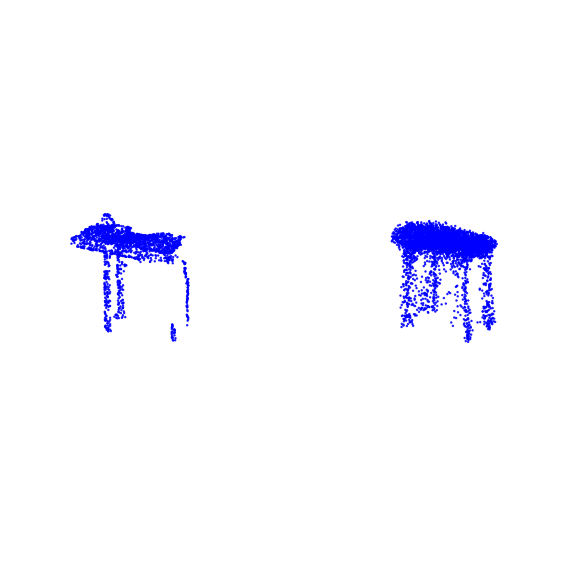

In [315]:
res = ae.reconstruct(feed, compute_loss=False)[0]
c = 1

for i, pc in enumerate(res):
    fig = plt.figure(figsize=(10, 10))
    recon = Point_Cloud(pc.reshape(4096, 3))
    feed_i = Point_Cloud(feed[i].reshape(2048, 3))
    
    plt.subplot(1, 2, 1, projection='3d')
    plt.axis('off')
    ax = fig.axes[0]    
    iccv.plot_3d_point_cloud(feed_i, axis=ax, in_u_sphere=True, elev=10, azim=35, show=False, s=8)
    
    plt.subplot(1, 2, 2, projection='3d')    
    plt.axis('off')
    ax = fig.axes[1]    
    iccv.plot_3d_point_cloud(recon, axis=ax, in_u_sphere=True, elev=10, azim=35, show=False, s=8)
    